In [1]:
%pylab agg
%matplotlib nbagg

import h5py

from scipy.signal import correlate
from scipy.signal import find_peaks
# from scipy.optimize import curve_fit

projectPath = 'X:/RIXS/Asmara'
baseAtom = 'O'
energyDispersion = 0.00535 #eV/subpixel

In [2]:
def get_xas(scanNumber):
    global projectPath
    global baseAtom
    
    if scanNumber < 10:
        filename = baseAtom+'_'+'000'+str(scanNumber)
    elif scanNumber < 100:
        filename = baseAtom+'_'+'00'+str(scanNumber)
    elif scanNumber < 1000:    
        filename = baseAtom+'_'+'0'+str(scanNumber)
    else:    
        filename = baseAtom+'_'+str(scanNumber)

    data = loadtxt(projectPath+'/XAS/'+filename+'.xas', comments='#')

    photonEnergy = data[:,0]
    TEY = data[:,1]
    TFY = data[:,2]
    RMU = data[:,3]
    
    return photonEnergy,TEY,TFY,RMU

def elastic_shift(pixelData,zeroType,peakHeight,peakWidth):

    global energyDispersion
    if zeroType == "peak":
        peaks, _ = find_peaks(pixelData,height=peakHeight,width=peakWidth)
    elif zeroType == "height":
        peaks, _ = pixelData[(pixelData>peakHeight)]
    else:
        peaks = pixelData
    xdataPixel = arange(len(pixelData))
    
    xdataPixel = xdataPixel[(peaks[-1]-2000):(peaks[-1]+200)]
    energyData = pixelData[(peaks[-1]-2000):(peaks[-1]+200)]
    
    xDataEnergy = (xdataPixel - peaks[-1]) * energyDispersion * -1

    return xDataEnergy,energyData

def x_corr(refData, uncorrData):

    corr = correlate(refData, uncorrData)
    lag = argmax(corr)
    corrData = roll(uncorrData, lag)

    return corrData

def get_rixs(scanNumber,zeroType='peak',peakHeight=10,peakWidth=3):
    global projectPath
    global baseAtom
    
    if scanNumber < 10:
        filename = baseAtom+'_'+'000'+str(scanNumber)
    elif scanNumber < 100:
        filename = baseAtom+'_'+'00'+str(scanNumber)
    elif scanNumber < 1000:    
        filename = baseAtom+'_'+'0'+str(scanNumber)
    else:    
        filename = baseAtom+'_'+str(scanNumber)

    f1 = h5py.File(projectPath+'/RIXS/'+filename+'_d1.h5', 'r')
    f2 = h5py.File(projectPath+'/RIXS/'+filename+'_d2.h5', 'r')
    f3 = h5py.File(projectPath+'/RIXS/'+filename+'_d3.h5', 'r')

    ccd1 = array(f1['entry']['analysis']['spectrum'][()])
    ccd2 = array(f2['entry']['analysis']['spectrum'][()])
    ccd3 = array(f3['entry']['analysis']['spectrum'][()])
    
    ccd1 = x_corr(ccd2,ccd1)
    ccd3 = x_corr(ccd2,ccd3)
    xdata,tempData = elastic_shift(ccd1+ccd2+ccd3,zeroType,peakHeight,peakWidth)
    
    return xdata,tempData

def get_scan(scans,zeroType='peak',peakHeight=10,peakWidth=3):
    for i,scanNumber in enumerate(scans):
        if i == 0:
            xdata,ydata = get_rixs(scanNumber,zeroType=zeroType,peakHeight=peakHeight,peakWidth=peakWidth)
            refdata = ydata
            sumdata = ydata
        else:
            _,ydata = get_rixs(scanNumber,zeroType=zeroType,peakHeight=peakHeight)
            ydata = x_corr(refdata,ydata)
            sumdata = sumdata+ydata
    return xdata,sumdata


In [ ]:
fig = figure()
E,TEY,TFY,RMU=get_xas(105)
plot(E,TEY);

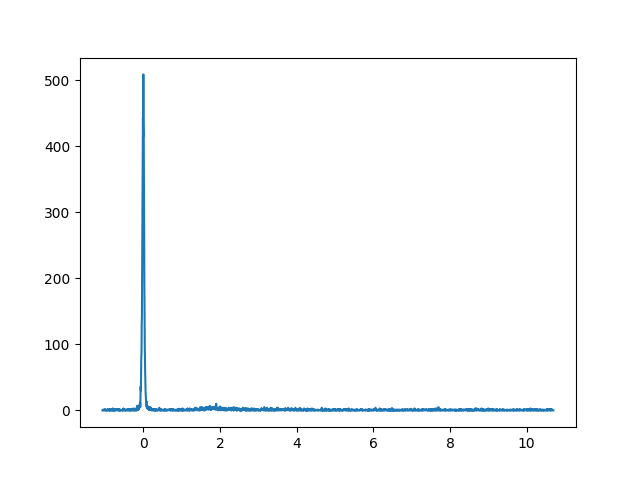

In [3]:
fig = figure()
X,Y=get_rixs(105)
plot(X,Y);

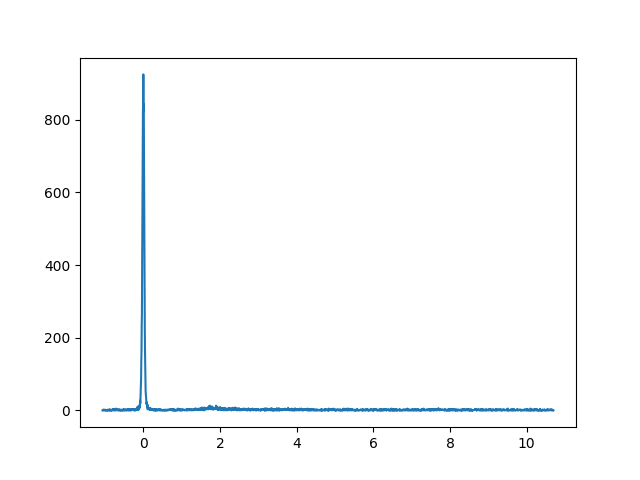

In [4]:
fig = figure()
X,Y=get_scan([105,106])
plot(X,Y);